## Result Visualization

In [11]:
## Required python libraries
import pandas as pd
import numpy as np
import scipy as sp
import scipy.signal
import os
import math
import sys
from scipy.interpolate import griddata

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torch.multiprocessing as mp

# to make this notebook's output stable across runs
np.random.seed(42)

pd.plotting.register_matplotlib_converters()

import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
%matplotlib inline
import seaborn as sns
import librosa
import matplotlib.font_manager as font_manager

In [7]:
# ------------------- plotly visualizatoin----------------------------------
from PIL import Image
import plotly.io as pio
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
from skimage import data

import scaleogram as scg 
from glob import glob
import glob
import scipy
from scipy.signal import welch
import wave                    # library handles the parsing of WAV file headers
import pywt
import soundfile as sf
import matplotlib.font_manager as font_manager

In [25]:
PROJECT_ROOT_DIR = "../../"
IMAGE_PATH = os.path.join(PROJECT_ROOT_DIR, "result_images", 'result_visualization')
os.makedirs(IMAGE_PATH, exist_ok=True)

## function for automatically save the diagram/graph into the folder 
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGE_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

plt.rcParams["axes.edgecolor"] = "black"
plt.rcParams["axes.linewidth"] = 2.50

In [5]:
def get_sample_directories(base_path, sample_numbers):
    sample_directories = []
    for sample_number in sample_numbers:
        sample_directories.append(os.path.join(base_path, f'segmented_25Hz/{sample_number}'))
    return sample_directories

Multimodal_dataset_PATH = "/home/chenlequn/Dataset/LDED_acoustic_visual_monitoring_dataset"
samples = [21, 22, 23, 26]
sample_directories = get_sample_directories(Multimodal_dataset_PATH, samples)

# Get lists of image and audio directories for each sample
image_directories = [os.path.join(sample_dir, 'images') for sample_dir in sample_directories]
audio_directories = [os.path.join(sample_dir, 'denoised_audio') for sample_dir in sample_directories]

In [9]:
classes = ('Laser-off', 'Defect-free', 'Defective')
# classes = ('Laser-off', 'Defect-free', 'Cracks', "Keyhole pores")
SAMPLE_RATE = 44100
LEARNING_RATE = 0.00001

### Use GPU if possible

In [12]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using {device}")
mp.set_start_method(method='forkserver', force=True)

Using cuda


### Annotation file

- Vision acoustic spatio-temporal registration has been done in our previous work. 
- Each frame (timestamp) corresponds to a robot TCP position.
- The duration for each frame is 0.01 seconds (sampling freqeuncy 10 Hz.)

In [36]:
# Combine all annotation files into one DataFrame
all_annotation_dfs = []
sample_number = 26

annotation_file = os.path.join(sample_directories[3], f'annotations_{sample_number}.csv')  # Update the file name
annotation_df = pd.read_csv(annotation_file)
annotation_df

,sample index,audio_file_name,image_file_name,name,class_ID,class_name_v2,class_ID_2,Layer number,Sample number,X,Y,Z
0,1,sample_26_1.wav,sample_26_1.jpg,Crack,2.0,Defective,2.0,1,26,0.051261,0.332409,9.593398
1,2,sample_26_2.wav,sample_26_2.jpg,Crack,2.0,Defective,2.0,1,26,0.053637,0.333638,-1.620712
2,3,sample_26_3.wav,sample_26_3.jpg,Crack,2.0,Defective,2.0,1,26,0.052480,0.332042,1.079153
3,4,sample_26_4.wav,sample_26_4.jpg,Defect-free,1.0,Defect-free,1.0,1,26,0.053354,0.334101,-0.517956
4,5,sample_26_5.wav,sample_26_5.jpg,Defect-free,1.0,Defect-free,1.0,1,26,0.052477,0.331523,0.617860
...,...,...,...,...,...,...,...,...,...,...,...,...
10981,10982,sample_26_10982.wav,sample_26_10982.jpg,Laser-off,0.0,Laser-off,0.0,50,26,0.049866,0.333670,20.111111
10982,10983,sample_26_10983.wav,sample_26_10983.jpg,Laser-off,0.0,Laser-off,0.0,50,26,0.049612,0.332770,19.226752
10983,10984,sample_26_10984.wav,sample_26_10984.jpg,Laser-off,0.0,Laser-off,0.0,50,26,0.049823,0.333603,20.365324
10984,10985,sample_26_10985.wav,sample_26_10985.jpg,Laser-off,0.0,Laser-off,0.0,50,26,0.049747,0.332576,18.765931


In [43]:
import plotly.express as px

def prediction_visualization_2D(file_name_prefix, column_name ):
    annotation_df[column_name] = annotation_df[column_name].astype(str)
    fig = px.scatter(annotation_df, x="X", y="Z", color=column_name,
                     title="Ground truth", color_discrete_sequence=[
                     'black', "blue", "orange", "red", "green"],
                     category_orders={ # replaces default order by column name
                     column_name: ["Laser-off", "Defect-free", "Crack", "Keyhole pores", ""]
                     },
                    )
    # fig.update_traces(marker=dict(size=10,
    #                               line=dict(width=0.1,
    #                                         color='DarkSlateGrey')),
    #                   selector=dict(mode='markers'))

    config = {
                  'toImageButtonOptions': {
                    'format': 'svg', # one of png, svg, jpeg, webp
                    'filename': 'custom_image',
                    # 'height': 700,
                    # 'width': 900,
                    'scale': 1 # Multiply title/legend/axis/canvas sizes by this factor
                  }
             }
    # fig.show()
    pio.write_html(fig, os.path.join(IMAGE_PATH, "2D_" + file_name_prefix + column_name + ".html"), auto_open=True, config=config)

In [44]:
prediction_visualization_2D(str(sample_number) + " ground truth ", "name")

In [39]:
import plotly.express as px

def spatial_feature_visualization(file_name_prefix, column_name ):
    
    fig = px.scatter_3d(annotation_df, x='X', y='Y', z='Z',
                        color=column_name,
                       color_discrete_sequence=[
                     'black', "blue", "orange", "red"],
                     category_orders={ # replaces default order by column name
                     column_name: ["Laser-off", "Defect-free", "Crack", "Keyhole pores"]
                     },
                    )

    angle = math.pi / 6 # 45 degrees
    camera = dict(
        # up=dict(x=0, y=math.sin(angle), z=math.sin(angle)),
        eye=dict(x=-1, y=2, z=0.9)
    )

    # https://plotly.com/python/reference/layout/xaxis/
    fig.update_layout(
        scene_camera=camera,
        title={
            'text': "Prediction",
            'y':0.9,
            'x':0.5,
            'xanchor': 'center',
            'yanchor': 'top'},
        font = {
                'family': 'arial' ,
                'size': 14
            }

    )

    fig.update_layout(scene = dict(xaxis = dict(nticks=6, range=[-10,100]),
                                   zaxis = dict(nticks=3,range=[0, 21]), # for 2 [1225, 1235]
                                   yaxis = dict(nticks=6, range=[-2,2]),
                                   ))

    fig.update_traces(marker=dict(size=10,
                                  # line=dict(width=0.1,
                                            # color='DarkSlateGrey')
                     ),
                      selector=dict(mode='markers'))


    fig.update_layout(
                      # width=1300, 
                      # height=700,
                      margin=dict(l=5, r=5, b=5, t=5, pad=25),
                      scene = dict(xaxis = dict(nticks=6, range=[-10,100]),
                                   zaxis = dict(nticks=6,range=[0, 21]), # for 2 [1225, 1235]
                                   yaxis = dict(nticks=6, range=[-2,2]),
                                   xaxis_title= dict(text='X (mm)', font_size = 20),
                                   yaxis_title= dict(text='Y (mm)', font_size = 20),
                                   zaxis_title= dict(text='Z (mm)', font_size = 20)),
                                   )


    config = {
              'toImageButtonOptions': {
                'format': 'svg', # one of png, svg, jpeg, webp
                'filename': 'custom_image',
                # 'height': 700,
                # 'width': 900,
                'scale': 1 # Multiply title/legend/axis/canvas sizes by this factor
              }
            }

    # fig.show()
    pio.write_html(fig, os.path.join(IMAGE_PATH, file_name_prefix + column_name + ".html"), auto_open=True, config=config)

In [40]:
spatial_feature_visualization(str(sample_number) + " ground truth ", "name")

### Grid visualization

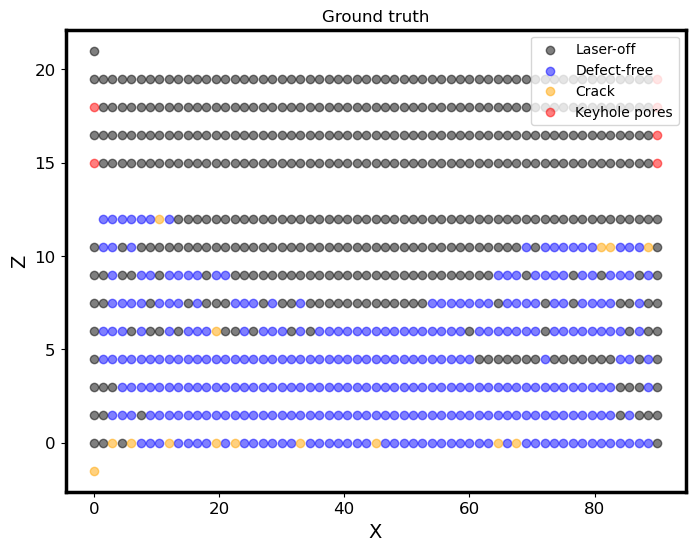

In [55]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Create a colormap
colormap = {"Laser-off": 'black', "Defect-free": 'blue', "Crack": 'orange', "Keyhole pores": 'red'}

# Create a new dataframe with 'X' and 'Z' rounded to nearest integer for grouping
grid_size = 1.5  # Change this value to control the size of the grid
df_rounded = annotation_df.copy()
df_rounded['X'] = (df_rounded['X'] / grid_size).round() * grid_size
df_rounded['Z'] = (df_rounded['Z'] / grid_size).round() * grid_size

# Group by 'X' and 'Z' and get the most frequent category in each group
df_grouped = df_rounded.groupby(['X', 'Z'])[column_name].agg(lambda x: pd.Series.mode(x)[0]).reset_index()

plt.figure(figsize=(8, 6))

# Plot each group with its corresponding color
for category in colormap.keys():
    df_category = df_grouped[df_grouped[column_name] == category]
    plt.scatter(df_category['X'], df_category['Z'], color=colormap[category], label=category, alpha=0.5)

plt.legend()
plt.xlabel('X')
plt.ylabel('Z')
plt.title('Ground truth')
plt.show()


In [48]:
import plotly.graph_objects as go
from scipy.interpolate import RegularGridInterpolator

# Assume df_selected is your DataFrame and ML_predictor is the column you want to display

# Generate grid (you may want to specify your own range and number of points)
grid_x, grid_y, grid_z = np.mgrid[annotation_df['X'].min():annotation_df['X'].max():100j, annotation_df['Y'].min():annotation_df['Y'].max():100j, annotation_df['Z'].min():annotation_df['Z'].max():100j]

# Interpolate data to fit the grid
interpolator = RegularGridInterpolator((annotation_df['X'], annotation_df['Y'], annotation_df['Z']), annotation_df[column_name])
grid_val = interpolator((grid_x, grid_y, grid_z))

# Create surface plot
fig = go.Figure(data=[go.Surface(z=grid_val, x=grid_x, y=grid_y)])
fig.update_layout(title='Predicted', autosize=False, scene=dict(xaxis_title='X', yaxis_title='Y', zaxis_title='Z'))
fig.show()


ValueError: The points in dimension 0 must be strictly ascending or descending